## SEGMENTATION AUTOMATIQUE DES VENTRICULES 

In [1]:
fichier_nom_date = "-" ## à entrer pour les tests
fichier_nom = fichier_nom_date.split("_")[0]

### Chargement des données

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, morphology, segmentation, measure, filters
from skimage.color import rgb2hsv, hsv2rgb
import nibabel as nib
import cv2

In [3]:

### chargement de l'image ###

#chargement de l'image
img= nib.load('./base/'+fichier_nom+'/'+fichier_nom_date+'.nii.gz')

img = nib.as_closest_canonical(img) #on met l'image dans un repère canonique
img_data = np.rot90(img.get_fdata(), k=1, axes=(1, 2)) #récupération des données de l'image

#chargement des plans
plans_sagittal = np.array([img_data[i,:,:] for i in range(0, img_data.shape[0])])
print(plans_sagittal.shape)
print(img_data.shape)
plans_coronal = np.array([img_data[:,i,:] for i in range(0, img_data.shape[1])])
print(plans_coronal.shape)
plans_axial = np.array([img_data[:,:,i] for i in range(0, img_data.shape[2])])

#affichage des plans
# for i in range(220,240,5):
#     plt.imshow(plans_sagittal[i], cmap='gray')
#     plt.show()

# for i in range(220,240,5):
#     plt.imshow(plans_coronal[i], cmap='gray')
#     plt.show()



# X est votre tableau 1D d'intensités de pixels
# kmeans = KMeans(n_clusters=k, random_state=42)
# kmeans.fit(X)
# labels = kmeans.predict(X)


(232, 512, 512)
(232, 512, 512)
(512, 232, 512)


### <span style="background-color:yellow">Pré-traitement</span>

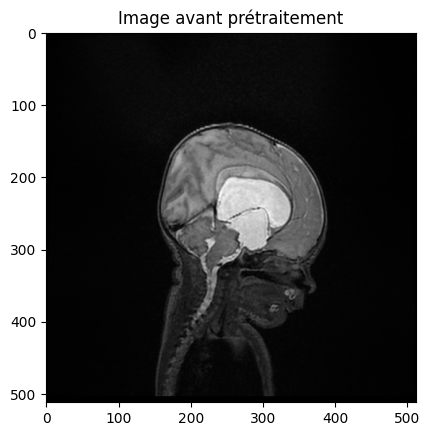

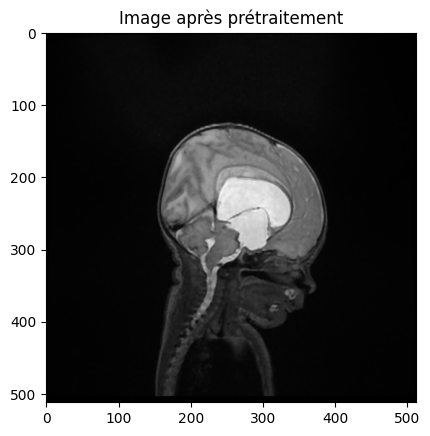

In [4]:
##pré traitement de l'image## 

plt.imshow(plans_sagittal[110], cmap='gray')
plt.title('Image avant prétraitement')
plt.show()

def pretraitement(plans_sagittal):
    #normalisation  --> facilite la segmentation car les valeurs sont entre 0 et 1  ###NORMALISATION SUR TOUT LE VOLUME
    plans_sagittal = (plans_sagittal - np.min(plans_sagittal))/(np.max(plans_sagittal) - np.min(plans_sagittal))

    #lissage --> permet de réduire le bruit

    plans_sagittal = filters.median(plans_sagittal)
    #plans_sagittal = filters.gaussian(plans_sagittal, sigma=0.5)
    return plans_sagittal

plans_sagittal = pretraitement(plans_sagittal)

plt.imshow(plans_sagittal[110], cmap='gray')
plt.title('Image après prétraitement')
plt.show()


Recherche d'une valeur typique de pixels pour chaque label pour initialisation du Kmeans

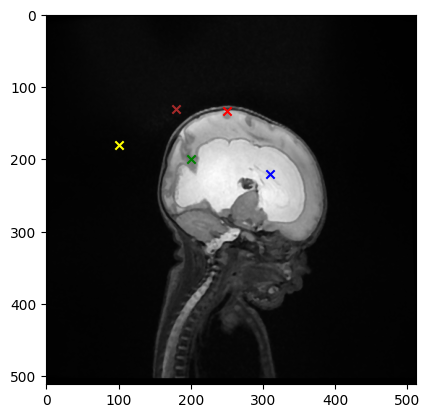

In [5]:
pixel_ventricule = [250,133]
pixel_cerveau = [200,200]
pixel_body = [310,220]
pixel_background = [100,180]
pixel_crane_contour = [180,130]


plt.imshow(plans_sagittal[130], cmap='gray')
plt.scatter(*pixel_ventricule,c='red', marker='x')  ## un pixel ventricule
plt.scatter(*pixel_crane_contour,c='brown', marker='x')  ## un pixel crâne
plt.scatter(*pixel_cerveau,c='green', marker='x')  ## un pixel cerveau hors ventricule
plt.scatter(*pixel_body,c='blue', marker='x')  ## un pixel body
plt.scatter(*pixel_background,c='yellow', marker='x')  ## un pixel background

plt.show()

In [6]:
pixel_ventricule = int(plans_sagittal[130][pixel_ventricule[0]][pixel_ventricule[1]] *255)
pixel_cerveau = int(plans_sagittal[130][pixel_cerveau[0]][pixel_cerveau[1]] *255)
pixel_body = int(plans_sagittal[130][pixel_body[0]][pixel_body[1]] *255)
pixel_background = int(plans_sagittal[130][pixel_background[0]][pixel_background[1]] *255)
pixel_crane_contour = int(plans_sagittal[130][pixel_crane_contour[0]][pixel_crane_contour[1]] *255)

print("Pixel ventricule: ", pixel_ventricule)  #pixel ventricule
print("Pixel cerveau: ",pixel_cerveau)  #pixel cerveau
print("Pixel corps: ",pixel_body)  #pixel body
print("Pixel arrière-plan: ",pixel_background)  #pixel background
print("Pixel crane contour: ",pixel_crane_contour)  #pixel_crane_contour

Pixel ventricule:  4
Pixel cerveau:  102
Pixel corps:  99
Pixel arrière-plan:  10
Pixel crane contour:  5



#### Histogramme

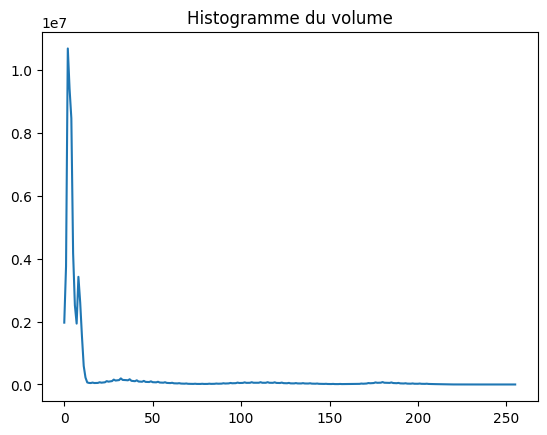

In [7]:
####FAIRE HISTOGRAMME et entrainer sur ces données ####

def histogramme(volume):
    hist = np.zeros(256)
    for i in range(0, len(volume)):
        for v in volume[i].flatten():
            hist[int(v*255)] += 1  #on multiplie par 255 pour avoir des valeurs entre 0 et 255 car les valeurs de l'image sont entre 0 et 1
    return hist

hist = histogramme(plans_sagittal) 
plt.plot(hist)
plt.title('Histogramme du volume')
plt.show() 



### <span style="background-color:yellow">Entrainement</span>

228648912308928.9


(array([ 24.,   0.,   0.,  54.,   0.,   0.,  70.,   0.,   0., 108.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

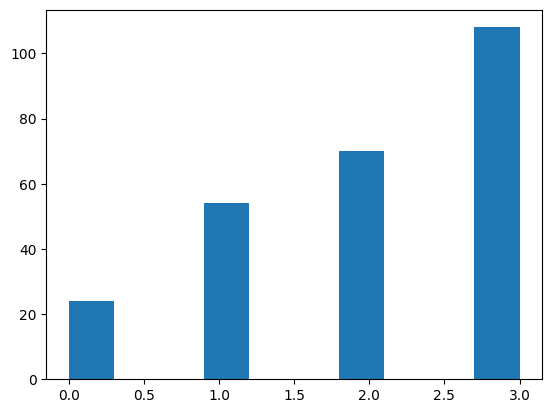

In [19]:
def my_Kmeans(k, volume):
    X = volume.reshape(-1,1)
    classes = [(255//k)*(i+1) for i in range(k)] #initialisation des classes uniformément  ##mettre valeur moyenne des labelss (à la main)
    #classes = [pixel_background, pixel_body,pixel_crane_contour, pixel_cerveau, pixel_ventricule]
    labels_3D = np.zeros(X.shape[0])
    converging = False
    prev_classes = np.zeros(k)
    min_iter = 50  ##MAX_INTER
    tour = 0
    while (not(converging) or (tour<min_iter)):  #tant que les classes ne convergent pas
        labels_3D, classes = attribution(X, classes, labels_3D)
        prev_classes = np.copy(classes) 
        labels_3D, classes, inertie = maximisation(X, classes, labels_3D)
        if np.all(classes == prev_classes):
            converging = True
        tour+=1
    return labels_3D, inertie, classes

def attribution(X, classes, labels_3D):
    #attribution / expectation
    for x in range(len(X)):
        dist_min = 255
        label = 0
        for c in range(len(classes)):  #on calcule la distance de x à chaque classe et on attribue x à la classe la plus proche
            if abs(x-classes[c]) < dist_min:
                dist_min = abs(x-classes[c])
                label = c
        labels_3D[x] = label
    return labels_3D, classes

def maximisation(X, classes, labels_3D):
    #mise à jour / maximisation
    inertie = 0
    for i in range(len(classes)):
        dico = {l: X[l] for l in range(len(X)) if labels_3D[l] == i}
        cles = list(dico.keys()) #intensités des pixels appartenant à la classe i
        values = list(dico.values()) # nombres de pixels appartenant à la classe i par intensité
        numerateur = 0
        for v in range(len(values)):
            numerateur+= values[v] * cles[v]
        if (np.sum(values)>0):
            classes[i] = numerateur/np.sum(values)  #on met à jour les classes en prenant la moyenne des valeurs des pixels appartenant à chaque classe
        else:
            classes[i] = numerateur # on ne met pas 0 pour ne pas avoir de problème dans la suite
            
        # centre de classe avec les coordonnées spatiales des pixels
        new_center = np.mean(values, axis=0)
        # Calculer l'inertie en utilisant les distances spatiales
        for pixel in values:
            inertie += np.sum((pixel - new_center) ** 2)
    return labels_3D, classes, inertie

res,inertie,centres = my_Kmeans(4, hist)
print(inertie)
plt.hist(res)

In [20]:
PLANS = [i for i in range(110, 160, 5)]
PAS = 5

On remarque que le label des ventricules n'est pas toujours le même.

Un nombre de 3 ou 4 clusters semble être le plus juste pour la mise en valeur des ventricules<br/><br/>
<span style="color:green">Déterminons le nombre de clusters optimal <strong>automatiquement</strong> que visuellement.. résultats plus justes => <strong>Méthode du coude</strong> </span>

Test avec  1  clusters ... 
Test avec  2  clusters ... 
Test avec  3  clusters ... 
Test avec  4  clusters ... 
Test avec  5  clusters ... 
Test avec  6  clusters ... 
Inertie pour chaque nombre de cluster:  [326785235789936.0, 298711882963311.9, 281723371046932.0, 228648912308928.9, 224055324612601.53, 224036639690184.7]
[326785235789936.0, 298711882963311.9, 281723371046932.0, 228648912308928.9, 224055324612601.53, 224036639690184.7]


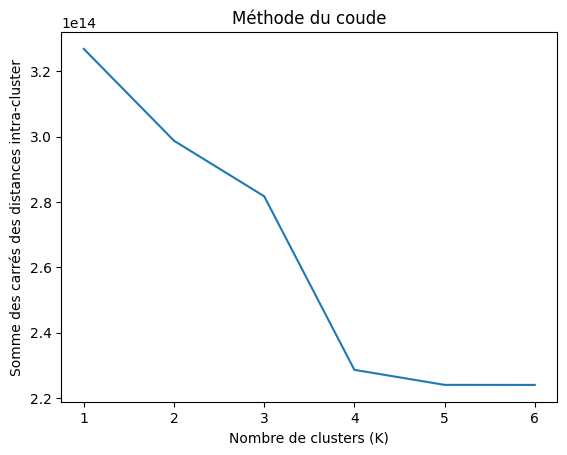

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

NB_CLUSTERS_MIN = 1
NB_CLUSTERS_MAX = 6  #EN COMPTANT L'EXCLU

def elbow_method(volume):    ###itération pour chaque cluster
    MSE = []
    for k in range(NB_CLUSTERS_MIN, NB_CLUSTERS_MAX+1):
        print('Test avec ', k, ' clusters ... ')
        _, _MSE, _ = my_Kmeans(k, volume)
        MSE.append(_MSE) 
    print('Inertie pour chaque nombre de cluster: ',MSE)
    return MSE

MSE_avg  = elbow_method(hist) 
print(MSE_avg)
plt.plot(range(NB_CLUSTERS_MIN, NB_CLUSTERS_MAX+1), MSE_avg)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Somme des carrés des distances intra-cluster') #inertie
plt.show()



Dernier point d'inflexion =  nombre de <strong> clusters</strong> plus judicieux


In [22]:
def dernier_point_d_inflexion(courbe):  ### K idéal
    dernier_inflexion = None
    
    for i in range(len(courbe) - 2, 1, -1):
        k=i+1  #premier cluster = 1 et non 0
        # Calcul des gradients 
        x1, y1 = i - 1, courbe[i - 1]
        x2, y2 = i + 1, courbe[i + 1]
        #calcul des params de la droite passant par les points (x1, y1) et (x2, y2)
        a = (y2 - y1) / (x2 - x1)
        b = y2 - a * x2

        print(f"Équation de la droite (entre points{i-1} et {i+1}) :", f"y = {a}x + {b}")

        # Visualisation point i
        y = courbe[i]
        y_droite = a * i + b
        if y < y_droite:
            dernier_inflexion = k
            break
    
    return dernier_inflexion

indice_dernier_inflexion = dernier_point_d_inflexion(MSE_avg)
print("Indice du dernier point d'inflexion :", indice_dernier_inflexion)


Équation de la droite (entre points3 et 5) : y = -2306136309372.1094x + 235567321237045.25
Indice du dernier point d'inflexion : 5


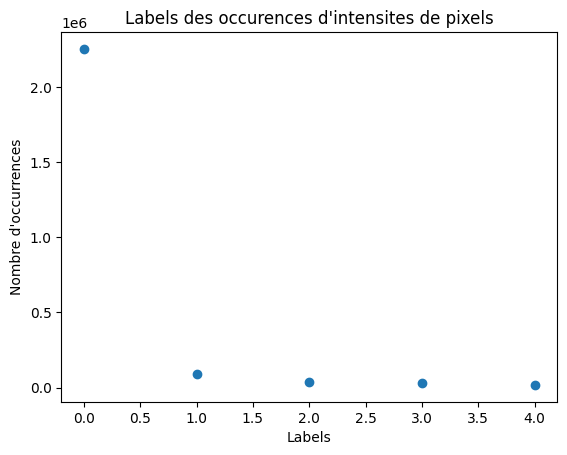

In [23]:
NB_CLUSTER = 5
#hist = np.array([i/hist[i] for i in range(1,len(hist))])     ##mettre ça en commentaire et revoir
labels_3D, _, centres = my_Kmeans(NB_CLUSTER, hist) 

#plt.hist(labels_3D, edgecolor='black', alpha=0.7)
plt.plot(range(NB_CLUSTER), [hist[labels_3D == i].mean() for i in range(NB_CLUSTER)], 'o')
plt.title('Labels des occurences d\'intensites de pixels')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'occurrences')
plt.show()

#print('Inertie : ', inertie)


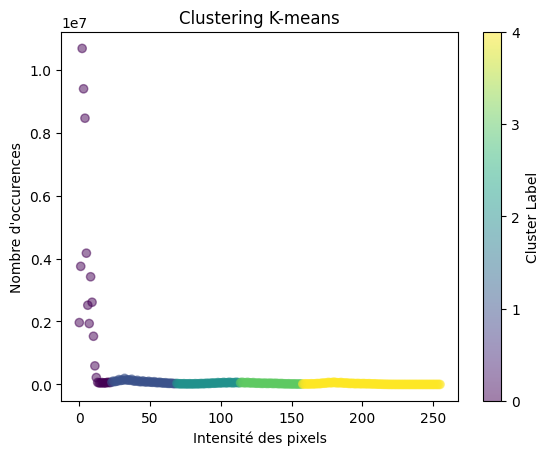

In [24]:

plt.scatter(range(len(hist)), hist, c=labels_3D, alpha=0.5)
plt.xlabel('Intensité des pixels')
plt.ylabel('Nombre d\'occurences')
plt.title('Clustering K-means')
plt.colorbar(label='Cluster Label', ticks=[i for i in range(NB_CLUSTER)])
plt.show()



In [25]:
## RECHERCHE DU LABEL DES VENTRICULES ##

def label_of_ventricule(labels_3D, volume):

    # calcul du centre du volume
    centre_volume = [volume.shape[0]//2, volume.shape[1]//2, volume.shape[2]//2]
    print('Centre du volume : ', centre_volume)

    # On prend le label dont les coordonnées ont une moyenne de distance au centre minimal
    for k in range(NB_CLUSTER):

        #--valeurs des pixels appartenant au label k
        intensites_label = [ind for ind in range(len(labels_3D)) if labels_3D[ind] == k]
        
        #--coordonnées des pixels appartenant au label k
        coord_label = np.argwhere(np.isin(np.round(volume * 255).astype(int), intensites_label))

        #--moyenne des distances de chaque coordonnée au centre
        distances = np.linalg.norm(coord_label - centre_volume, axis=1)
        moyenne_distance = np.mean(distances)

        print('Distance moyenne des coordonnnées du cluster ', k+1, ' au centre: ', moyenne_distance)
        if k==0:
            dist_min = moyenne_distance
            label_ventricule = k
        elif moyenne_distance < dist_min:
            dist_min = moyenne_distance
            label_ventricule = k
    
    return label_ventricule

label_ventricule = label_of_ventricule(labels_3D, plans_sagittal)
print('Label du ventricule : ', label_ventricule)


Centre du volume :  [116, 256, 256]
Distance moyenne des coordonnnées du cluster  1  au centre:  225.17088117243463
Distance moyenne des coordonnnées du cluster  2  au centre:  148.15885456134222
Distance moyenne des coordonnnées du cluster  3  au centre:  93.9426616551211
Distance moyenne des coordonnnées du cluster  4  au centre:  94.11078465917915
Distance moyenne des coordonnnées du cluster  5  au centre:  69.31290841681069
Label du ventricule :  4


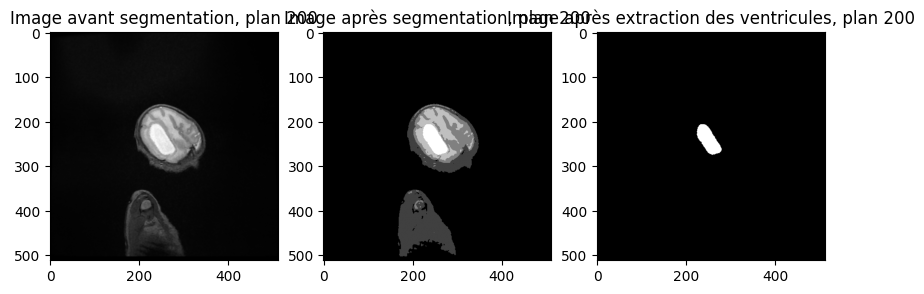

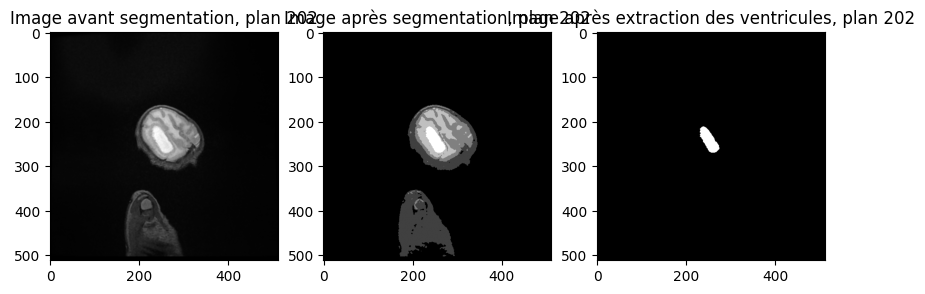

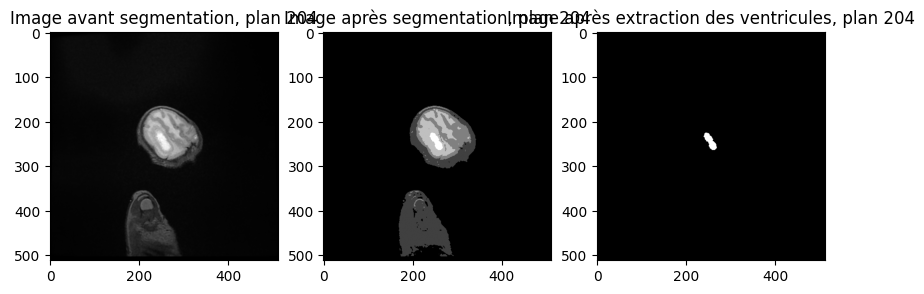

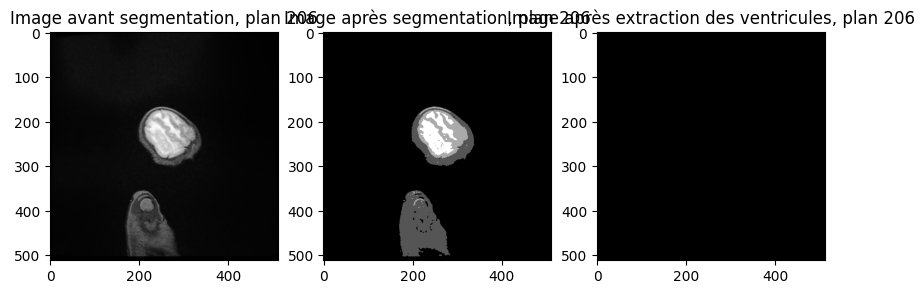

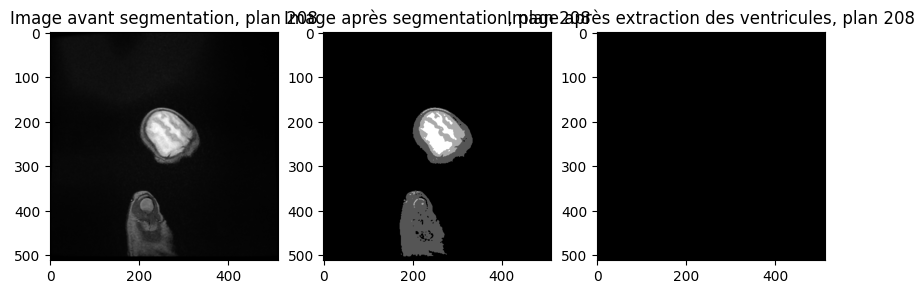

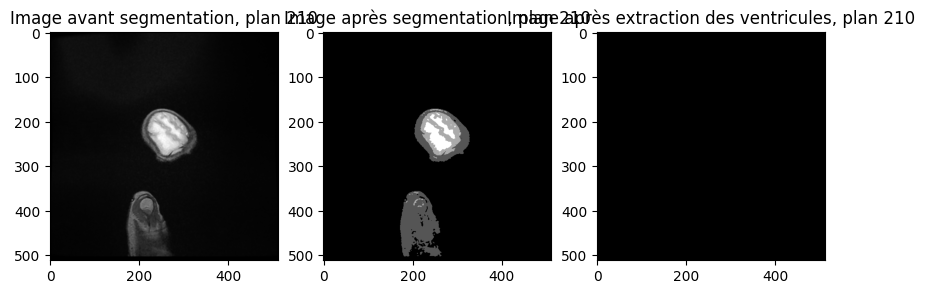

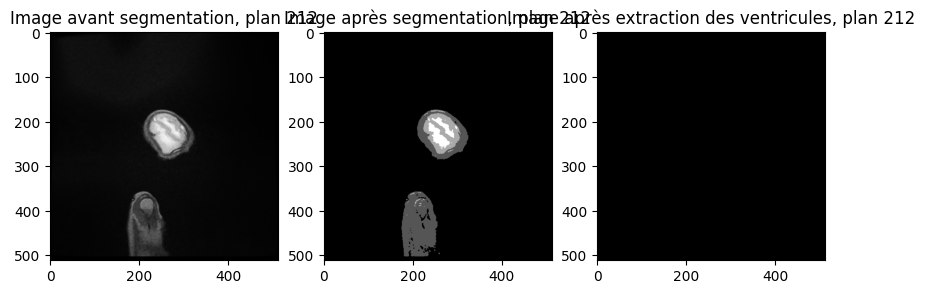

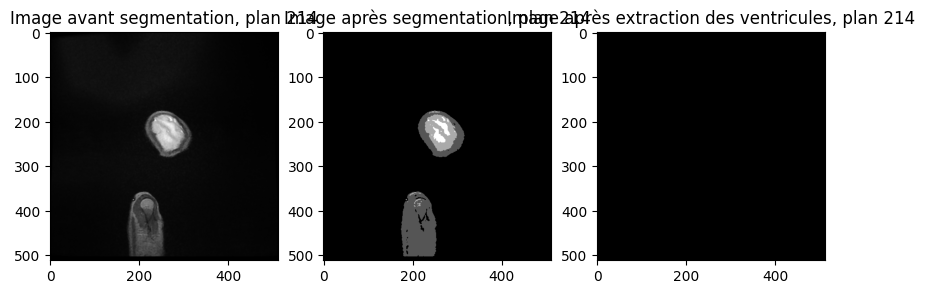

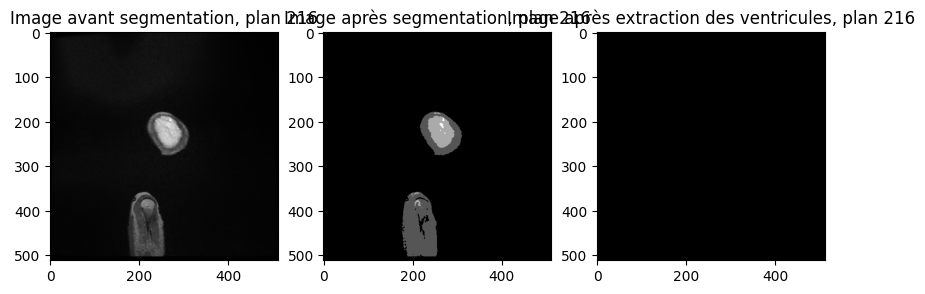

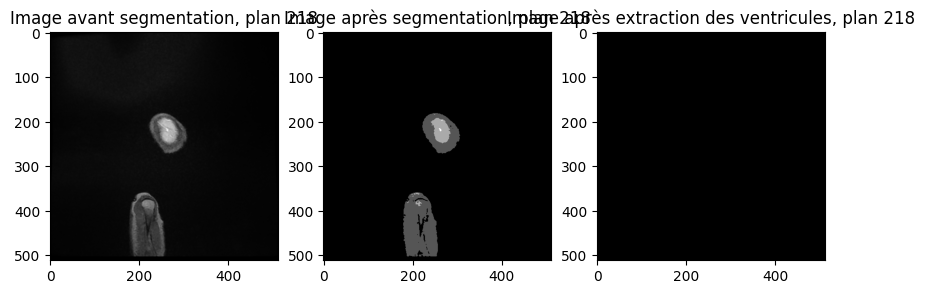

In [26]:
#reconstruction segmentée  

def reconstruction_segmentee(volume, label_ventricule, labels):
    volume_reconstruit = (labels[(volume * 255).astype(int)] == label_ventricule)
    return volume_reconstruit

segmented_images = reconstruction_segmentee(plans_sagittal, 4, labels_3D)

for i in range(200,220,2):

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(plans_sagittal[i], cmap='gray')
    ax[0].set_title('Image avant segmentation, plan ' + str(i))

    ax[1].imshow(labels_3D[(plans_sagittal * 255).astype(int)][i], cmap='gray')
    ax[1].set_title('Image après segmentation, plan ' + str(i))

    ax[2].imshow(segmented_images[i], cmap='gray')
    ax[2].set_title('Image après extraction des ventricules, plan ' + str(i))

    plt.show()

### <span style="background-color:yellow">Post traitement </span>
#### On récupère la plus grande region HYPERINTENSE sur la sequence T2 de l'IRM


<span style= 'color:red'>Par défaut, les ventricules peuvent être coupés donc avant de récupérer la plus grande région, on va rejoindre ses parties coupés.</span>


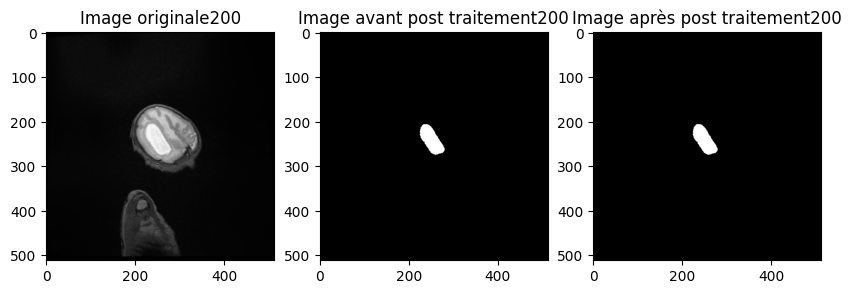

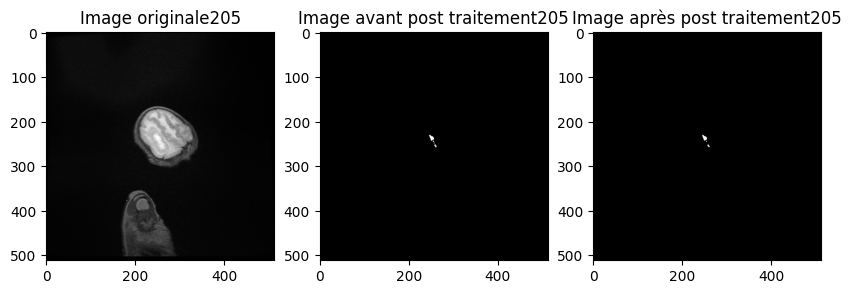

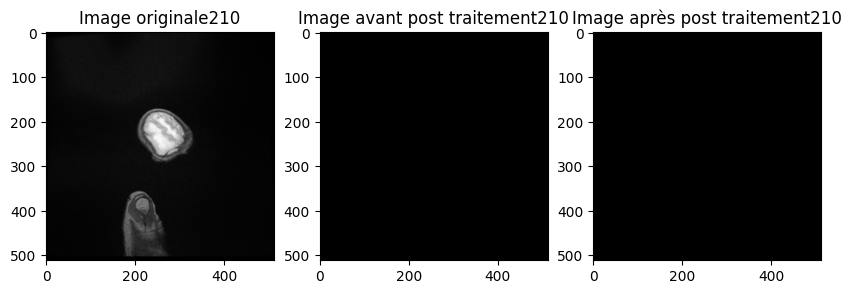

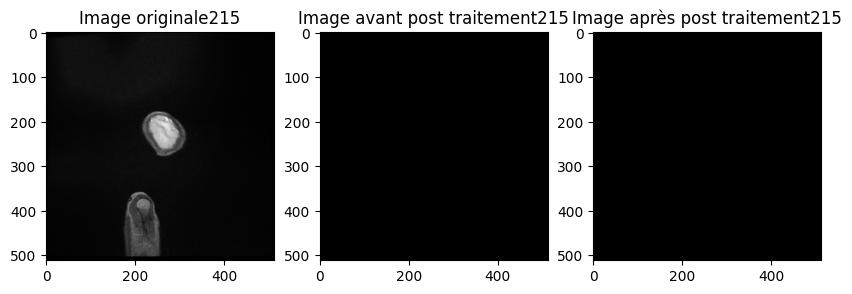

In [27]:
## post traitement de l'image ##  

def post_traitement(labels):
    smoothed_labels = filters.median(labels)
    return smoothed_labels

for i in range(200,220,5):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(plans_sagittal[i], cmap='gray')
    ax[0].set_title('Image originale'+str(i))

    ax[1].imshow(segmented_images[i], cmap='gray')
    ax[1].set_title('Image avant post traitement'+str(i))

    smoothed_labels = post_traitement(segmented_images)
    ax[2].imshow(smoothed_labels[i], cmap='gray')
    ax[2].set_title('Image après post traitement'+str(i))
    plt.show()

#smoothed_labels = post_traitement(segmented_images)

Filtre médian efficace : de petites regions segmentées sous le même label que les ventricules ont disparus

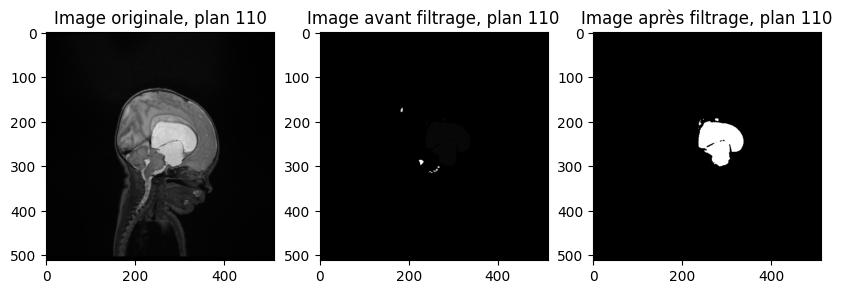

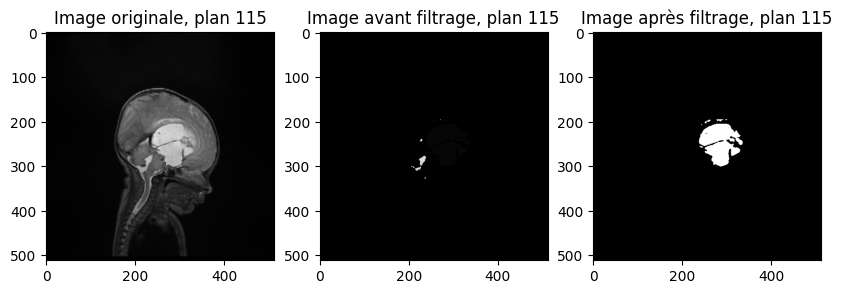

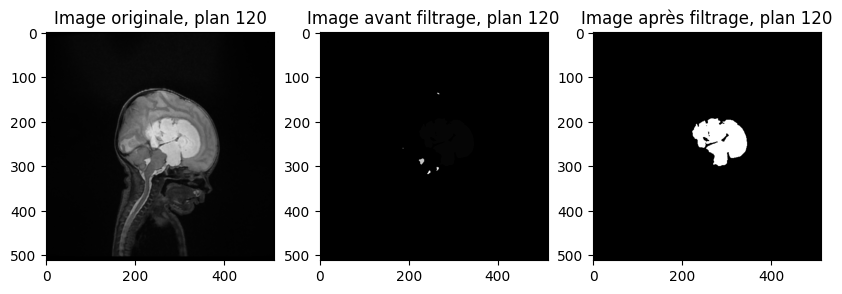

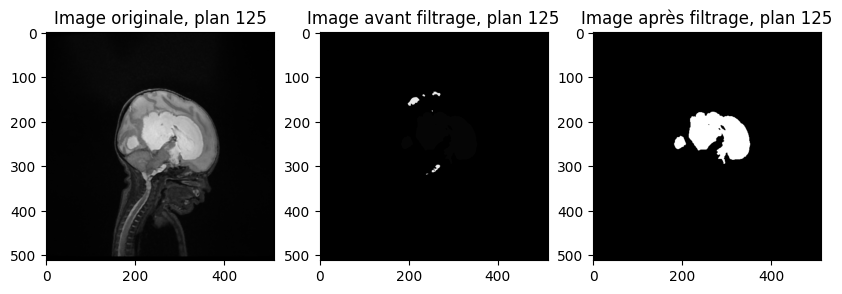

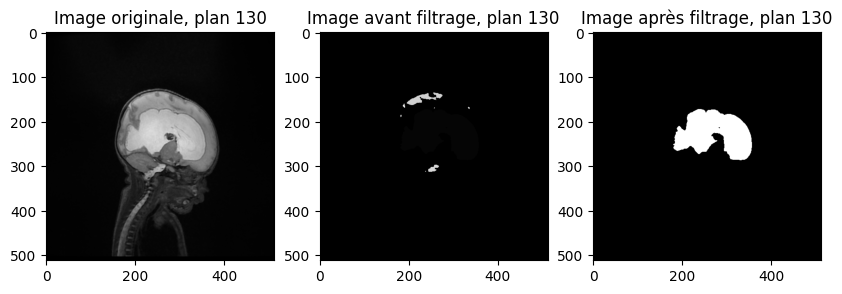

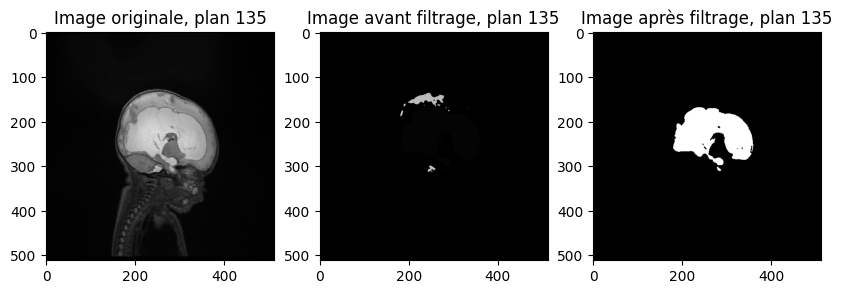

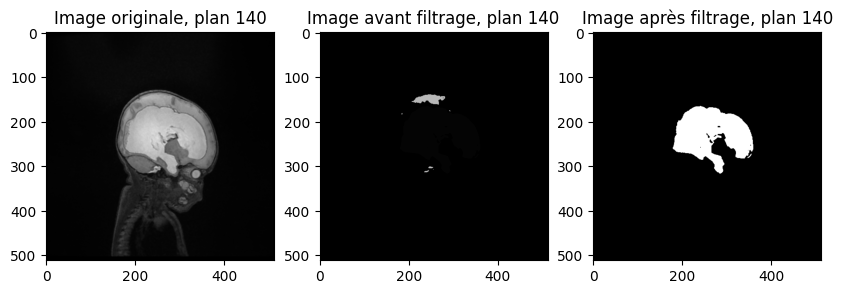

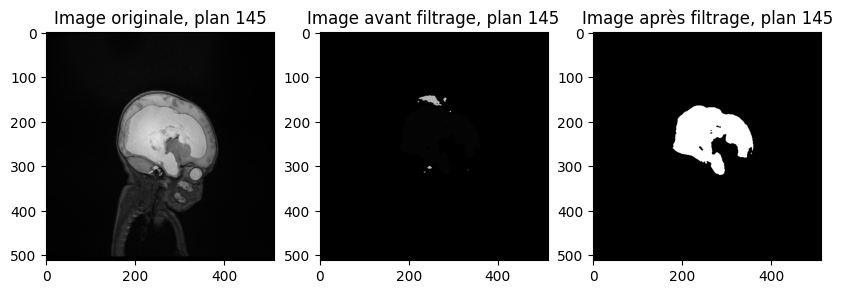

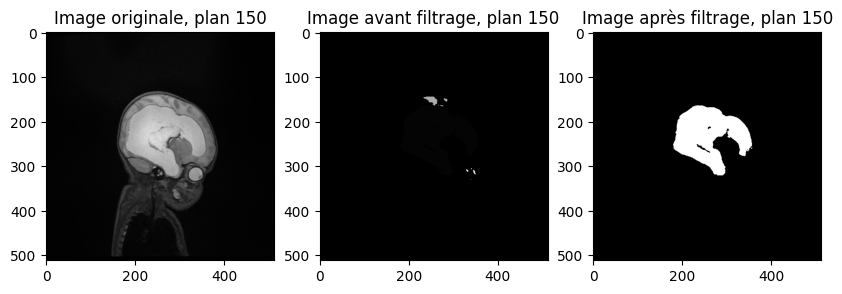

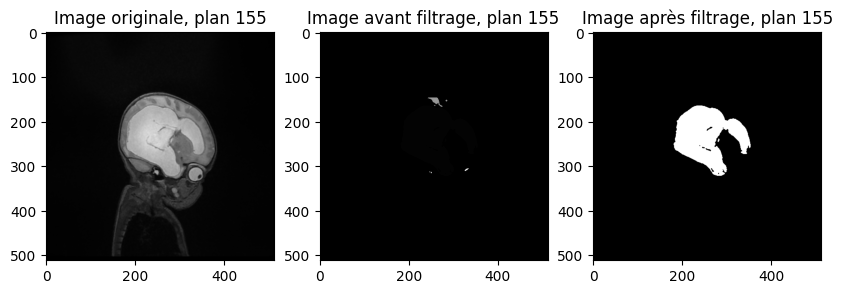

In [28]:
from scipy import ndimage

import numpy as np
from scipy import ndimage

def filter_regions_by_density(binary_image):
    labeled_image, num_features = ndimage.label(binary_image)  # on identifie les régions de l'image, 
    region_sizes = ndimage.sum(binary_image, labeled_image, range(num_features + 1))  # on calcule la taille de chaque région

    #moy_size = np.average(region_sizes)  # on calcule la taille moyenne de l'ensemble des régions
    label_region_ventr = np.argmax(region_sizes)  # on identifie la région la plus grande
    ventricules_region = np.where(labeled_image == label_region_ventr, 1, 0)

    # print(moy_size)
    # mm = region_sizes[region_sizes > moy_size]
    # print(mm)

    # mask = region_sizes > moy_size 
    # ventricules_region = mask[labeled_image]
    
    return label_region_ventr, ventricules_region, labeled_image

label_region_ventr, ventricules_region, labeled_image = filter_regions_by_density(smoothed_labels)

for i in PLANS:
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(plans_sagittal[i], cmap='gray', vmin = 0, vmax= 1)
    ax[0].set_title('Image originale, plan ' + str(i))

    ax[1].imshow(labeled_image[i],cmap='gray')
    ax[1].set_title('Image avant filtrage, plan '+str(i))

    ax[2].imshow(ventricules_region[i], cmap='gray',  vmin = 0, vmax= 1)
    ax[2].set_title('Image après filtrage, plan '+str(i))
    plt.show()



### **Chargement des IRM segmentées manuellement**

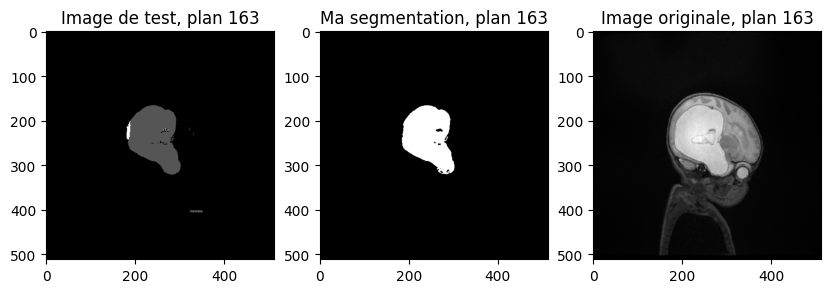

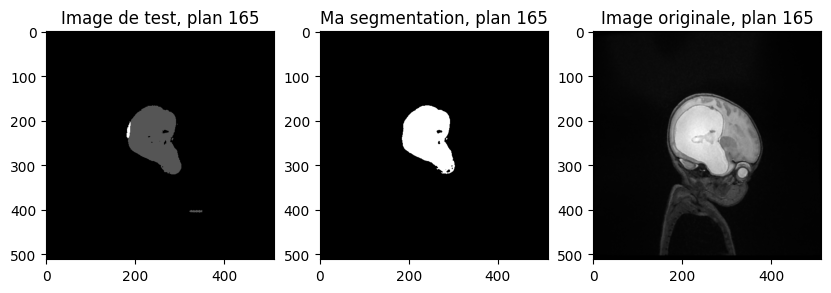

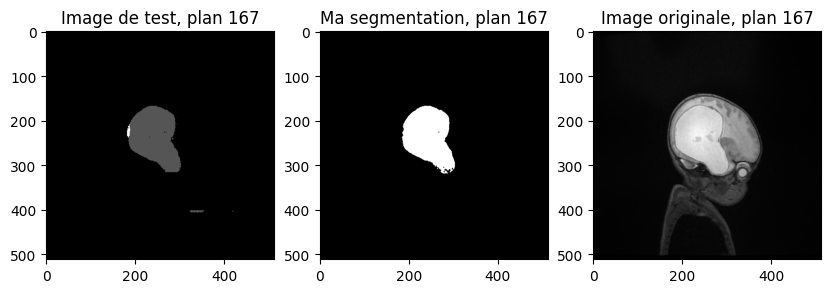

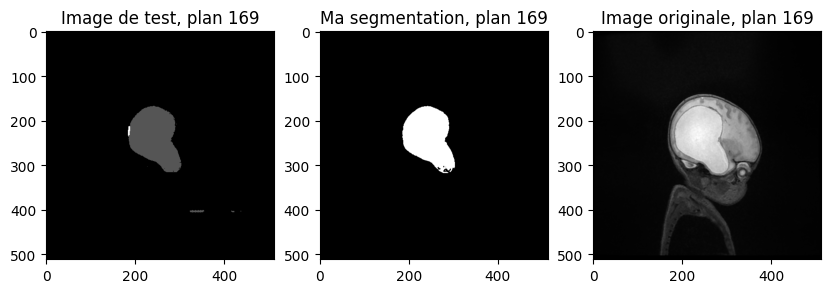

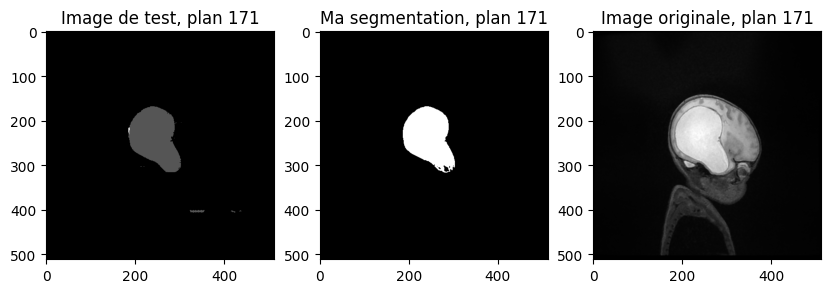

In [29]:
## chargement des données déjà segmentées ##
#chargement de l'image
img_seg = nib.load('./base/'+fichier_nom+'/'+fichier_nom_date+'_Segmentation-label.nii.gz')

img_seg = nib.as_closest_canonical(img_seg) #on met l'image dans un repère canonique
#img_data_seg = img_seg.get_fdata() #récupération des données de l'image
img_data_seg = np.rot90(img_seg.get_fdata(), k=1, axes=(1, 2)) 

#chargement des plans
plans_sagittal_seg = np.array([img_data_seg[i,:,:] for i in range(img_data_seg.shape[0])])
plans_coronal_seg = np.array([img_data_seg[:,i,:] for i in range(img_data_seg.shape[1])])
plans_axial_seg = np.array([img_data_seg[:,:,i] for i in range(img_data_seg.shape[2])])



for i in range(168-5,168+5,2):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    
    ax[0].imshow(plans_sagittal_seg[i], cmap='gray')
    ax[0].set_title('Image de test, plan ' + str(i))  # celle de la base

    ax[1].imshow(ventricules_region[i], cmap='gray')
    ax[1].set_title('Ma segmentation, plan ' + str(i))  # la mienne

    ax[2].imshow(plans_sagittal[i], cmap='gray')
    ax[2].set_title('Image originale, plan ' + str(i))
    plt.show()


Toute la région souhaitée n'apparait pas toujours (quatrième ventricule manquante)

Comme volume segmenté prend à la fois les ventricules et les taches de sang, nous allons juste récupérer le volume de ventricules. <br/>
=> <span style="color:red">Hypothèse: On estime que la région des ventricules est la deuxième plus grande région de l'image: <br>  <span style='color:blue'>nombre pixels sang <  nombre pixels ventricules < nombre pixels fond noir</span>

=> **Récuperer le 4e ventricule (annoté sur les IRM de test)**

Text(0.5, 1.0, 'Plan central des ventricules: plan 121')

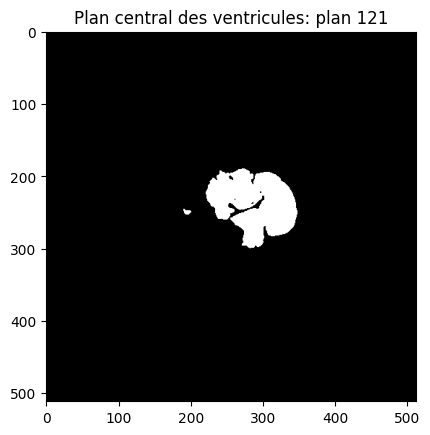

In [30]:
# fonction qui récupère la valeur du plan z central de la region des ventricules:
def milieu_ventricule(volume):
    indices = np.argwhere(volume == 1)
    zmin = np.min(indices[:,0])
    zmax = np.max(indices[:,0])
    return (zmax+zmin)//2

plan_milieu_ventricules = milieu_ventricule(ventricules_region)
plt.imshow(ventricules_region[plan_milieu_ventricules],cmap='gray')
plt.title('Plan central des ventricules: plan '+str(plan_milieu_ventricules))


On observe que le 4e ventricule se trouve au centre de la region des ventricules. On récupère la région la plus dense et la plus au centre.

In [31]:
def quatrieme_ventricule(plan_central,labeled_image, label_ventricule):
    dico_nb_par_label = {i:0 for i in np.unique(labeled_image)}
    for p in range(plan_central-2, plan_central+2):
        for l in np.unique(labeled_image[p]):
            segment_label = np.where(labeled_image[p]==l,1,0)
            dico_nb_par_label[l]+=np.sum(segment_label.flatten())

    #on exclut le label des ventricules et le label du fond noir
    dico_nb_par_label[label_ventricule] = 0
    dico_nb_par_label[0] = 0
    return max(dico_nb_par_label, key=dico_nb_par_label.get)

dico_label_central = quatrieme_ventricule(plan_milieu_ventricules,labeled_image,label_region_ventr)
print("Le label du quatrième ventricule est", dico_label_central)

reg_quatrieme_ventricule = np.where(labeled_image==dico_label_central, 1, 0)

Le label du quatrième ventricule est 34


Les voxels du 4e ventricule sont ajoutés à la région ventriculaire principale

In [32]:
all_ventricules = np.logical_or(labeled_image == dico_label_central, labeled_image == label_region_ventr).astype(int)

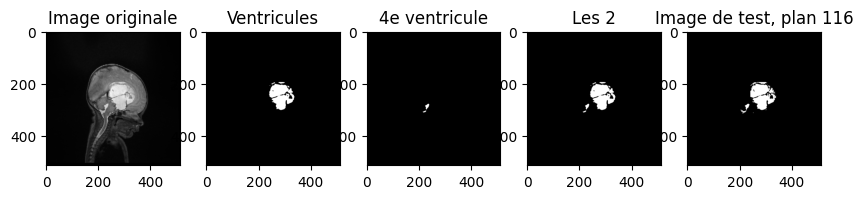

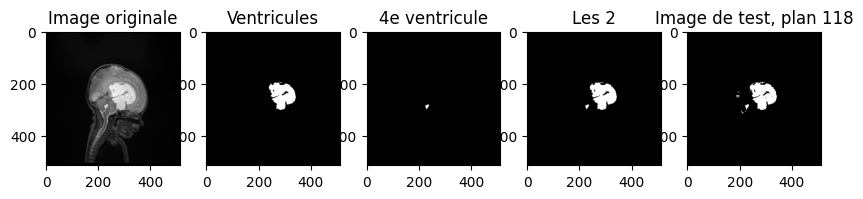

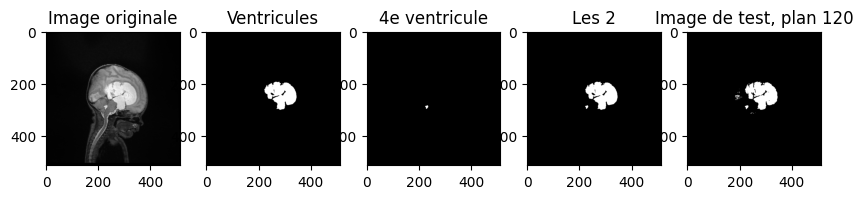

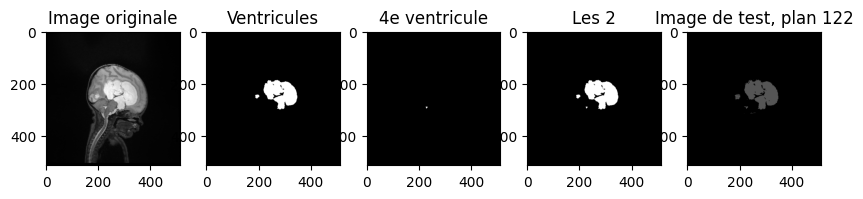

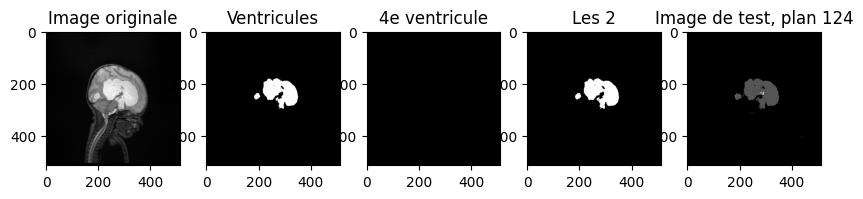

In [33]:
for i in range(plan_milieu_ventricules-5,plan_milieu_ventricules+5, 2):
    fig, ax = plt.subplots(1, 5, figsize=(10, 5)) 
    ax[0].imshow(plans_sagittal[i],cmap='gray')
    ax[0].set_title('Image originale')

    ax[1].imshow(ventricules_region[i], cmap='gray')
    ax[1].set_title('Ventricules')

    ax[2].imshow(reg_quatrieme_ventricule[i], cmap='gray')
    ax[2].set_title('4e ventricule')

    ax[3].imshow(all_ventricules[i], cmap='gray')
    ax[3].set_title('Les 2')

    ax[4].imshow(plans_sagittal_seg[i],cmap='gray')
    ax[4].set_title('Image de test, plan '+str(i))

    plt.show()

In [34]:

# enregistrer mon travail

# saving_ventricules_region = np.array([np.rot90(ventricules_region[i], k=-1) for i in range(ventricules_region.shape[0])])
# nib.save(nib.Nifti1Image(saving_ventricules_region, affine=img.affine), 'my_'+str(fichier_nom_date)+'_seg.nii.gz') 


### <span style='color:blue'>Autres méthodes testées pour la segmentation du 4e ventricule

**Algorithme DBSCAN** :

Implémentation de l'algorithme en entier:

In [35]:
def distance_euclidienne(voxel1, voxel2):
     return np.sqrt(np.sum((voxel1 - voxel2) ** 2))

def dbscan(labeled_image, ventricules_region, m=3, epsilon=1.73):
    ind_ventricules_region = np.argwhere(ventricules_region == 1)
    
    # Récupérer les points à partir de labeled_image qui ne sont pas dans les ventricules
    ind_labeled_img = np.argwhere((labeled_image != 0) & (ventricules_region == 0))

    print(len(ind_ventricules_region), len(ind_labeled_img))
    # on observe les voxels voisins de chaque voxel dans la région des ventricules dans un rayon de epsilon et on les ajoute à la région si leur densité est supérieure ou égale à m 
    for i in ind_ventricules_region:
        neighbours = []
        for j in ind_labeled_img:
            if distance_euclidienne(i, j) < epsilon and j not in ind_ventricules_region:
                print(i,j)
                neighbours.append(j)
        if len(neighbours) >= m:
            ind_ventricules_region = np.concatenate((ind_ventricules_region, neighbours), axis=0)

    new_ventricules_region = np.zeros_like(ventricules_region)
    for i in ind_ventricules_region:
        new_ventricules_region[tuple(i)] = 1

    return new_ventricules_region
                        

#new_ventricules_region = dbscan(labeled_image, ventricules_region)

Utilisation de la librairie:

In [36]:
from sklearn.cluster import DBSCAN

def dbscan_segmentation(labeled_image, ventricules_region, epsilon, min_samples):
    # Récupérer les points à partir de labeled_image qui ne sont pas dans les ventricules
    points = np.argwhere((labeled_image != 0) | (ventricules_region == 1)) 
    
    # Récupérer les points des régions de ventricules déjà segmentées
    # init_points = np.argwhere(ventricules_region == 1)
    
    # # Concaténer les points d'initialisation avec les autres points
    # all_points = np.concatenate((points, init_points))

    # DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    
    # masque de segmentation
    segmented_region = np.zeros_like(labeled_image)
    for label, point in zip(labels, points):
        if label != -1:  # Ignorer les points considérés comme du bruit
            segmented_region[tuple(point)] = 1
    
    return segmented_region

# Paramètres DBSCAN
epsilon = 3  # Distance maximale entre deux points pour qu'ils soient considérés comme voisins
min_samples = 5  # Nombre minimum de points dans un voisinage pour former un cluster

#external_ventricules_dbscan = dbscan_segmentation(labeled_image, ventricules_region, epsilon, min_samples)


In [37]:
# for i in PLANS:
#     fig, ax = plt.subplots(1, 4, figsize=(10, 5))

#     ax[0].imshow(plans_sagittal[i], cmap='gray', vmin = 0, vmax= 1)
#     ax[0].set_title('Image originale, plan ' + str(i))

#     ax[1].imshow(ventricules_region[i], cmap='gray', vmin = 0, vmax= 1)
#     ax[1].set_title('Image avant DBSCAN, plan '+str(i))

#     ax[2].imshow(labeled_image[i])
#     ax[2].set_title('Image avec les labels, plan '+str(i))

#     ax[3].imshow(external_ventricules_dbscan[i], cmap='gray',  vmin = 0, vmax= 1)
#     ax[3].set_title('Image après DBSCAN, plan '+str(i))
#     plt.show()

*==> DBSCAN pas efficace car bien trop lent travaillant sur une segmentation régionale*

**Algorithme REGION GROWING**

In [ ]:
def region_growing_histogram(hist, start_point, threshold_distance):
    region = [start_point]
    region_intensity_mean = hist[start_point]
    convergence = False

    # bornes de l'histogramme
    hist_min = 0
    hist_max = len(hist) - 1

    region_intensity_mean = start_point
    moyenne_prec = region_intensity_mean

    # Propagation de la région
    while not convergence:
        current_point = region.pop(0) 
        moyenne_prec = region_intensity_mean
        # intensités voisines au current point
        neighbors = [current_point - 1, current_point + 1]
        
        for neighbor in neighbors:
            # Vérification des limites de l'histogramme
            if hist_min <= neighbor <= hist_max:
                # Calcul de la distance entre l'intensité du voisin et la moyenne de la région
                intensity_distance = np.abs(neighbor - region_intensity_mean)

                # Si la distance est inférieure au seuil, on ajoute le voisin à la région
                if intensity_distance <= threshold_distance:
                    region.append(neighbor)
                    # Mise à jour de la moyenne de l'intensité
                    region_intensity_mean = np.sum([hist[r]*r for r in np.unique(region)])/np.sum([hist[r] for r in np.unique(region)])

        convergence = (region_intensity_mean == moyenne_prec)
        
    return region


start_point = 210  # Intensité d'un ventricule
threshold_distance = 10  

#result_region = region_growing_histogram(hist, start_point, threshold_distance)
#print("Région résultante :", result_region)


In [ ]:
# le volume est mis à 1 pour les intensités de pixels appartenant à la région result_region
def region_growing(volume, region):
    return np.isin(np.round(volume * 255).astype(int), region).astype(int)

#segmented_region_growing = region_growing(plans_sagittal, result_region)


In [ ]:
# for i in PLANS:
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#     ax[0].imshow(plans_sagittal[i], cmap='gray')
#     ax[0].set_title('Image originale, plan ' + str(i))

#     ax[1].imshow(segmented_region_growing[i], cmap='gray')
#     ax[1].set_title('Image après croissance de région, plan ' + str(i))

#     plt.show()

*==> L'algorithme ne donne pas de résultats satisfaisants*

## Mise en forme

(232, 512, 3, 512)
(232, 512, 3, 512)
(232, 512, 512, 3)
(232, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


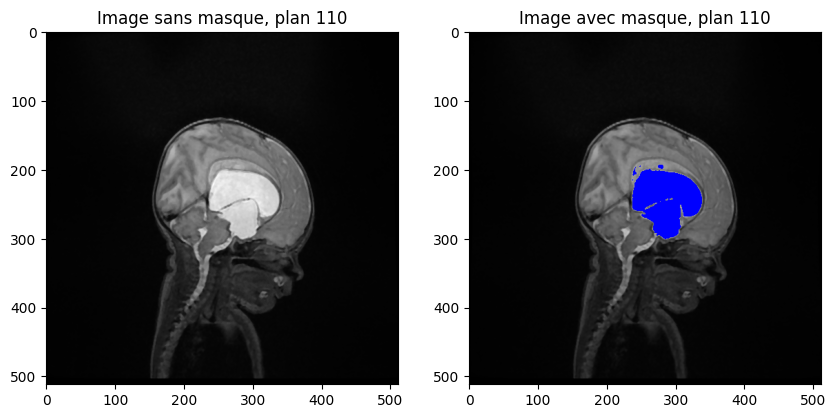

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


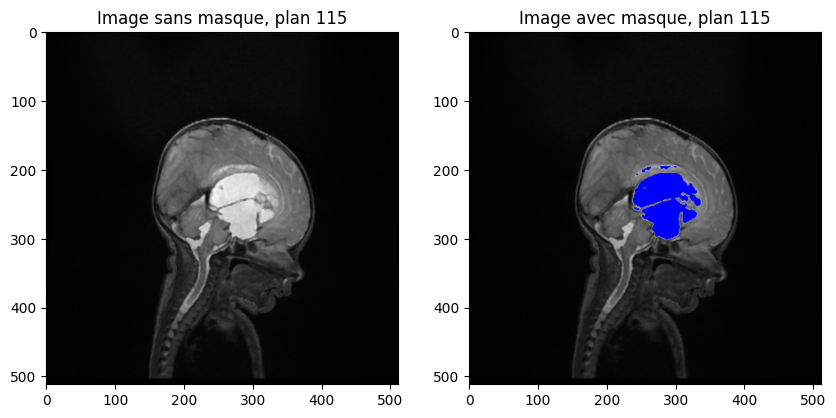

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


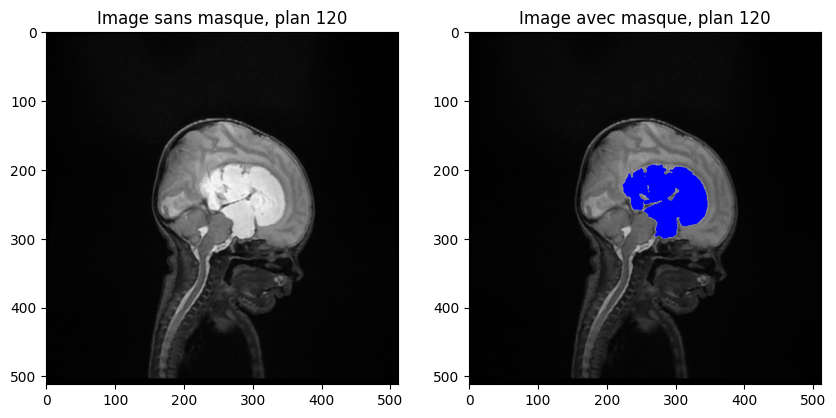

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


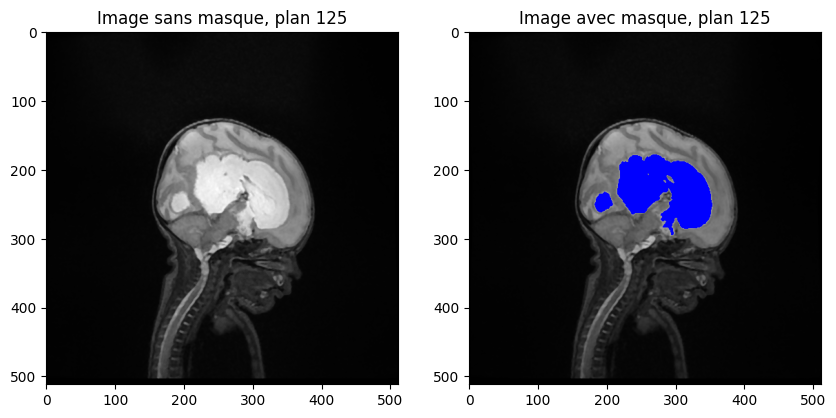

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


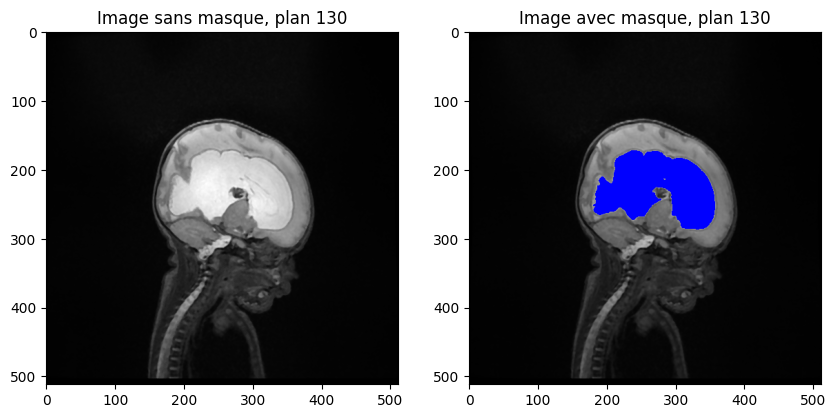

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


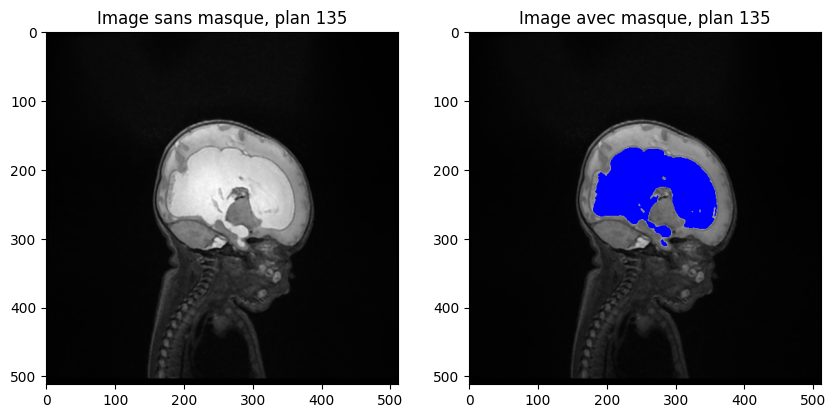

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


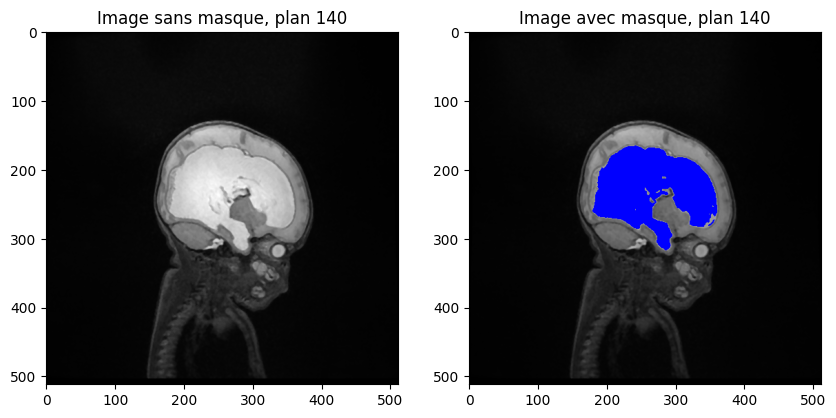

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


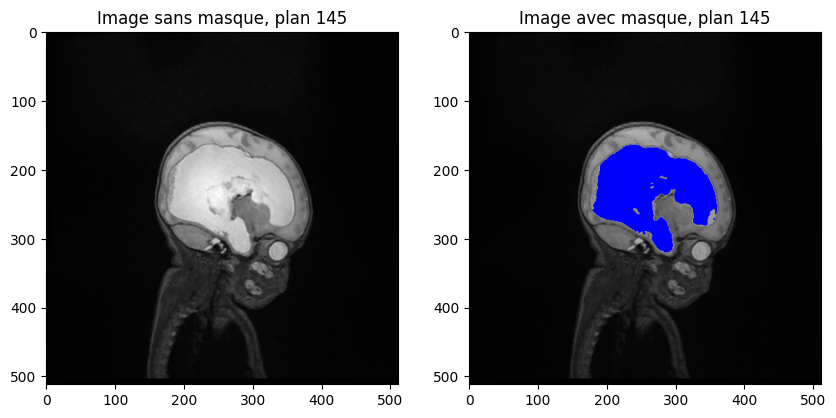

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


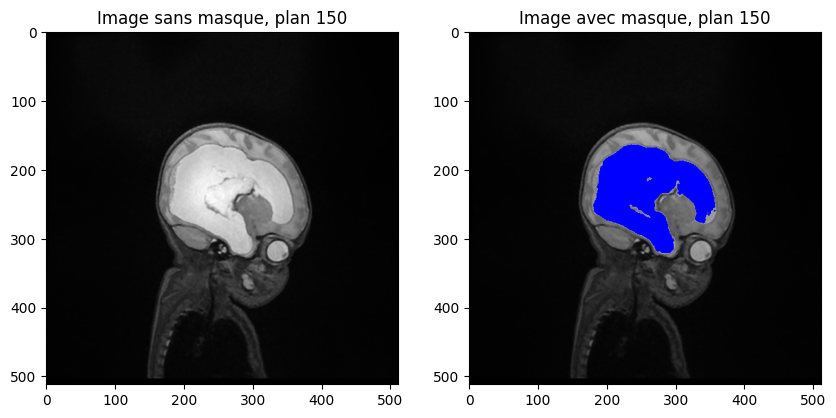

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


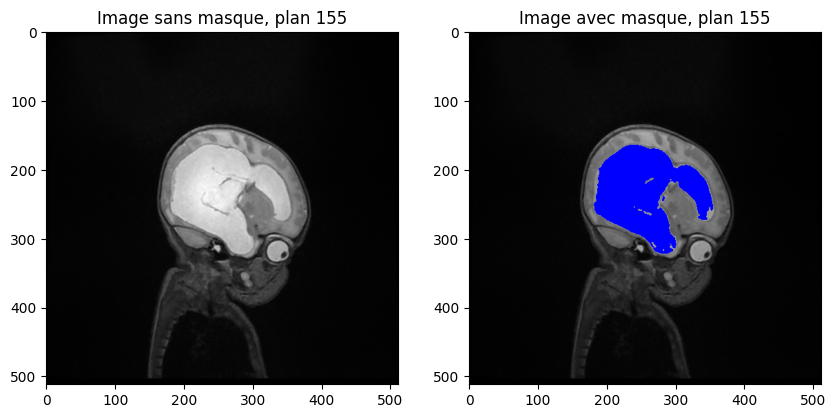

In [42]:

import cv2

## ajout du masque sur l'image ##

def coloration_region(volume, volume_binaire):
    # copie du volume en niveaux de gris pour la coloration
    pp = np.array([[[i,i,i] for i in row] for row in volume])
    vb = np.array([[[i*255,i*255,i*255] for i in row] for row in volume_binaire]).astype(np.uint8)
    print(pp.shape)
    print(vb.shape)
    # Transposer le volume binaire pour avoir la forme correcte
    vb = np.transpose(vb, (0, 1, 3, 2))
    pp = np.transpose(pp, (0, 1, 3, 2)) 
    print(vb.shape)
    print(pp.shape)
    # Mettre en bleu les pixels blancs du volume binaire dans le volume de couleur
    res = np.where((vb == [255, 255, 255]), [0, 0, 255], pp)
    return res


resultat = coloration_region(plans_sagittal, ventricules_region)

for i in PLANS:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(plans_sagittal[i], cmap='gray')
    ax[0].set_title('Image sans masque, plan ' + str(i))
    ax[1].imshow(resultat[i])
    ax[1].set_title('Image avec masque, plan ' + str(i))
    plt.show()


## <span style='color:green'>Accuracy

Fichier TEST Données

In [38]:
# on récupère le nombre de pixels de chaque région
labels_seg, nb_seg = np.unique(plans_sagittal_seg, return_counts=True)
occurrences = dict(zip(labels_seg, nb_seg)) #on met les labels et les occurences dans un dictionnaire
nb_seg = np.sort(nb_seg)
print('Labels pour chaque région: ',labels_seg)
print('Nombre de pixels de chaque région: ',nb_seg)

# on récupère le nombre de pixels de la région des ventricules
nb_ventricule_seg = nb_seg[-2]   #on estime que la région des ventricules est la deuxième plus grande région de l'image ( toujours moins de sang que de ventricules)
print('Nombre de pixels de la région des ventricules: ',nb_ventricule_seg)

# on récupère le label de la région des ventricules
for v in occurrences:
    if occurrences[v] == nb_ventricule_seg:
        label_ventricule_seg = v
print('Label de la région des ventricules: ',label_ventricule_seg)


# NOTATION : 
### nb_ventricule_seg = |S|
### {coordonnées des pixels de la région des ventricules} = S

Labels pour chaque région:  [0. 1. 3.]
Nombre de pixels de chaque région:  [   32084  1743835 59041489]
Nombre de pixels de la région des ventricules:  1743835
Label de la région des ventricules:  1.0


Mes données

In [39]:
coord_seg = np.argwhere(plans_sagittal_seg == label_ventricule_seg)  #on récupère les coordonnées des pixels de la région des ventricules
print('Coordonnées des pixels de la région des ventricules: ',coord_seg)

coord = np.argwhere(ventricules_region == 1)  #on récupère les coordonnées des pixels de la région des ventricules
print('Coordonnées des pixels de la région des ventricules: ',coord)
nb_ventricule = len(coord)
print('Nombre de pixels de la région des ventricules: ',nb_ventricule)

### coord_seg = S
### coord = R
### nb_ventricule = |R|

Coordonnées des pixels de la région des ventricules:  [[ 34 261 251]
 [ 34 261 252]
 [ 34 261 256]
 ...
 [218 407 395]
 [218 407 402]
 [218 408 402]]
Coordonnées des pixels de la région des ventricules:  [[ 38 250 248]
 [ 38 250 249]
 [ 38 250 250]
 ...
 [205 257 260]
 [205 257 261]
 [205 258 260]]
Nombre de pixels de la région des ventricules:  1708285


### <span style='color:green'>Indice de Dice : </span>
--> Pour mesurer similarité entre 2 régions
$$ Dice(S,R) = 
2 \times \frac{|S \cap R|}{|S| + |R|},    ∈ [0,1]
$$

avec <br/>
$S$ = ensemble des coordonnées des voxels de la région des ventricules dans l'image test;    $|S|$ = nombre de voxels de la région des ventricules dans l'image test <br/>
$R$ = ensemble des coordonnées des voxels de la région des ventricules dans l'image apprentissage;   $|R|$ = nombre de voxels de la région des ventricules dans l'image apprentissage <br/><br/>
Si Dice(S,R) tend vers 0 alors aucune superposition entre les 2 régions vs si  Dice(S,R) tend vers 1, superposition parfaite <br/><br/>

Dans code:<br/>
<span style='color:blue'>
$S$ = *coord_seg* SARAH<br/>
$R$ = *coord* NOTRE<br/>  
$|R|$ = *nb_ventricule*<br/>
$|S|$ = *nb_ventricule_seg*<br/></span>

In [40]:
##Indice de DICE

def dice_coefficient(S, R, lenS, lenR):
    S = [a * 1000000 + b * 1000 + c for a, b, c in S] #on transforme les coordonnées en entiers pour accélérer l'algo
    R = [a * 1000000 + b * 1000 + c for a, b, c in R]
    intersection = len(np.intersect1d(S, R)) #on récupère l'intersection des deux régions
    print('Intersection des deux régions: ',intersection)
    return 2. * intersection / (lenR + lenS)

dice = dice_coefficient(coord, coord_seg, nb_ventricule, nb_ventricule_seg)
print('Indice de DICE: ',dice)


Intersection des deux régions:  1683111
Indice de DICE:  0.9751173192125419


## **Volume de LCR**

In [41]:
dimensions_voxel= img.header.get_zooms()
print("Dimensions des voxels: ",dimensions_voxel)
volume_LCR = nb_ventricule * np.prod(dimensions_voxel) 
print("VOLUME TOTAL DE LIQUIDE CEPHALO-RACHIDIEN: ",volume_LCR, "mm3 soit ", volume_LCR*1e-6, "L")

volume_LCR_seg = nb_ventricule_seg * np.prod(dimensions_voxel)
print(volume_LCR_seg)

Dimensions des voxels:  (0.5000005, 0.5, 0.5)
VOLUME TOTAL DE LIQUIDE CEPHALO-RACHIDIEN:  213535.8286434412 mm3 soit  0.2135358286434412 L
217979.58288133144


### Enregistrement du masque

In [ ]:
# saving_ventricules_region = np.array([np.rot90(ventricules_region[i], k=-1) for i in range(ventricules_region.shape[0])])
# saving_ventricules_region = saving_ventricules_region.astype(np.float32) 
# nom_save = './masques_ok/my'+fichier_nom+'_Segmentation.nii.gz'
# nib.save(nib.Nifti1Image(saving_ventricules_region, header=img_seg.header, affine=img_seg.affine), nom_save)